[Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385v1.pdf)

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [2]:
# dataset
train_data = torchvision.datasets.MNIST('./data', train=True, download=True,
                                        transform=transforms.ToTensor())
test_data = torchvision.datasets.MNIST('./data', train=False, download=True,
                                         transform=transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 206125459.19it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 31719218.07it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 82162824.14it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4210061.61it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
# Import our own defined functions
from Common import show_img, plot_loss_acc

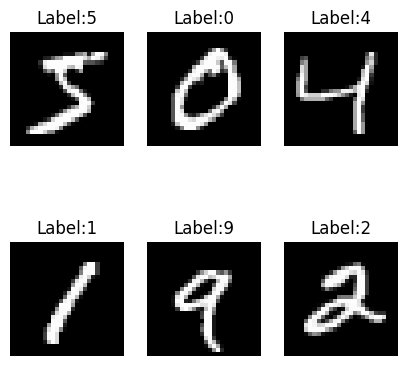

In [4]:
show_img(train_data, figsizes=(5, 5))

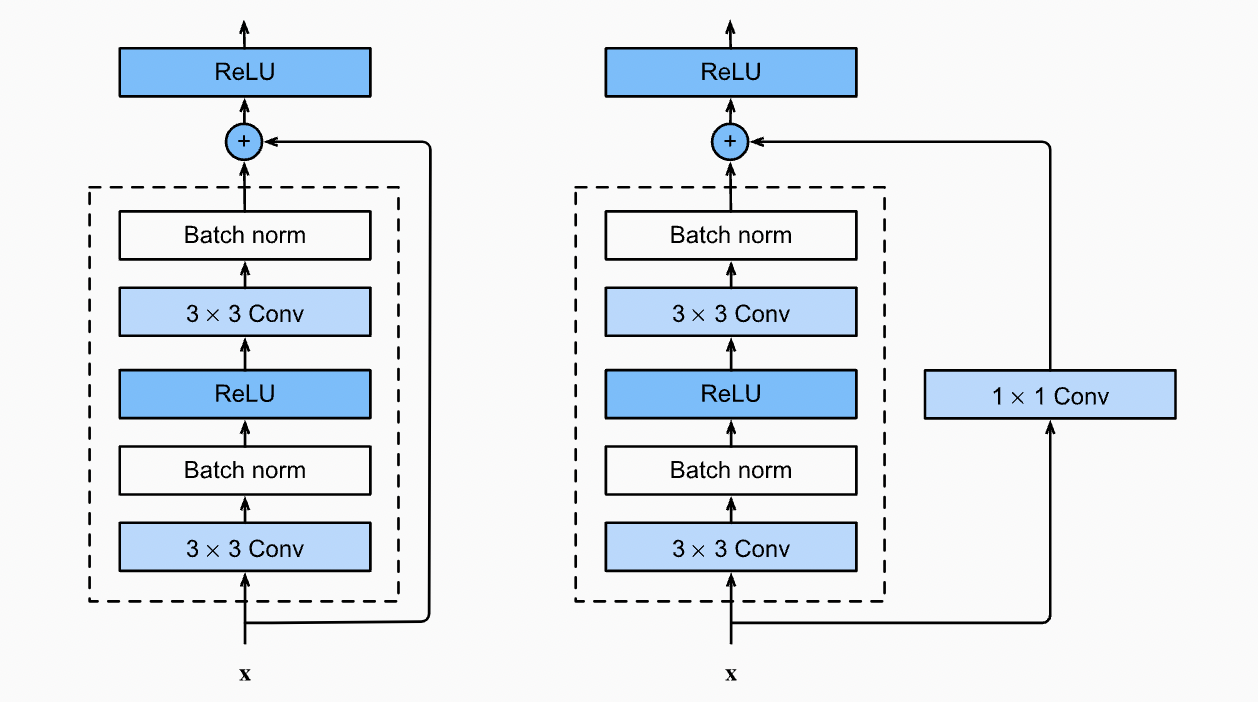

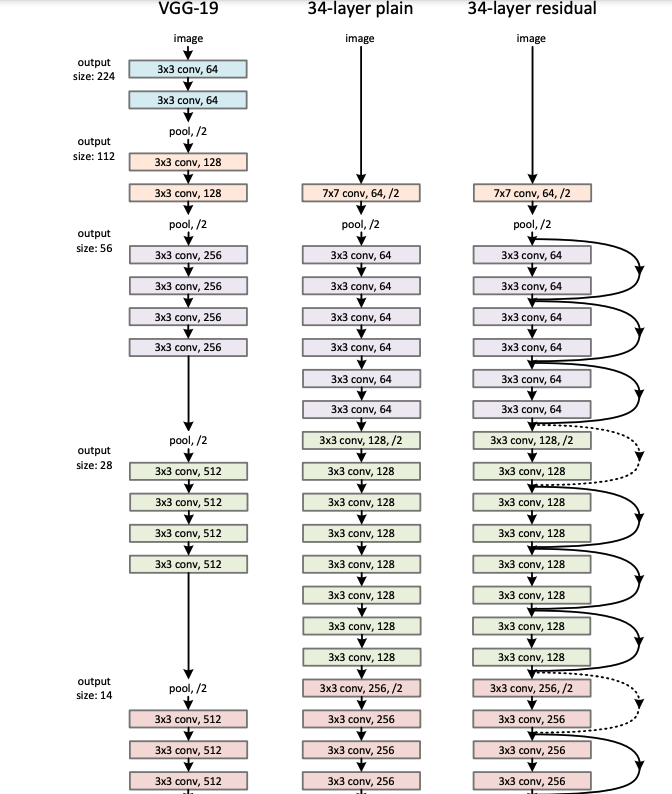

From the above picture we can see that as long as it is the first residual block, the picture size will be halved! Therefore, in order to allow the input and output to be added normally, a convolution kernel of size 1 needs to be introduced in shortcut!

In [5]:
# 1.Define the residual block as shown above
class res_block(nn.Module):
  def __init__(self, in_channels, num_channels, stride=1, first_block=False):
    super().__init__()
    self.first_block = first_block
    self.conv1 = nn.Conv2d(in_channels, num_channels, kernel_size=3, padding=1, stride=stride)
    self.batch1 =  nn.BatchNorm2d(num_channels)
    self.relu1 = nn.ReLU()
    self.conv2  = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
    self.batch2 = nn.BatchNorm2d(num_channels)
    self.relu2 = nn.ReLU()
    if first_block:
      self.conv1x1 = nn.Conv2d(in_channels, num_channels, kernel_size=1, stride=stride)

  def forward(self, x):
    y = self.batch2(self.conv2(self.relu1(self.batch2(self.conv1(x)))))
    if self.first_block:
      x = self.conv1x1(x)
    y += x
    return self.relu2(y)

**Next we will create an 18-layer network**

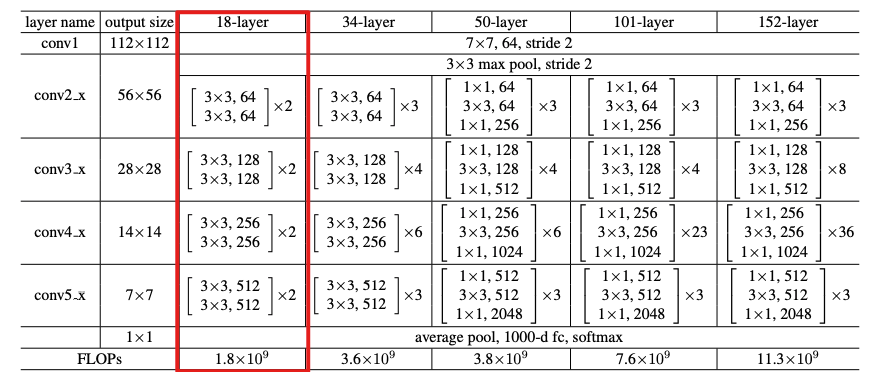

In [6]:
# 2.Build the model in the red box
def blks(in_channels, num_channels, num_blks, first_block=False):
  layers = []
  if first_block:
    blk1 = res_block(in_channels, num_channels, stride=2, first_block=first_block)
  else:
    blk1 = res_block(in_channels, num_channels)
  blk2 = res_block(num_channels, num_channels)
  layers.append(blk1)
  layers.append(blk2)
  for i in range(num_blks-1):
    layers.append(blk2)
    layers.append(blk2)
  return nn.Sequential(*layers)


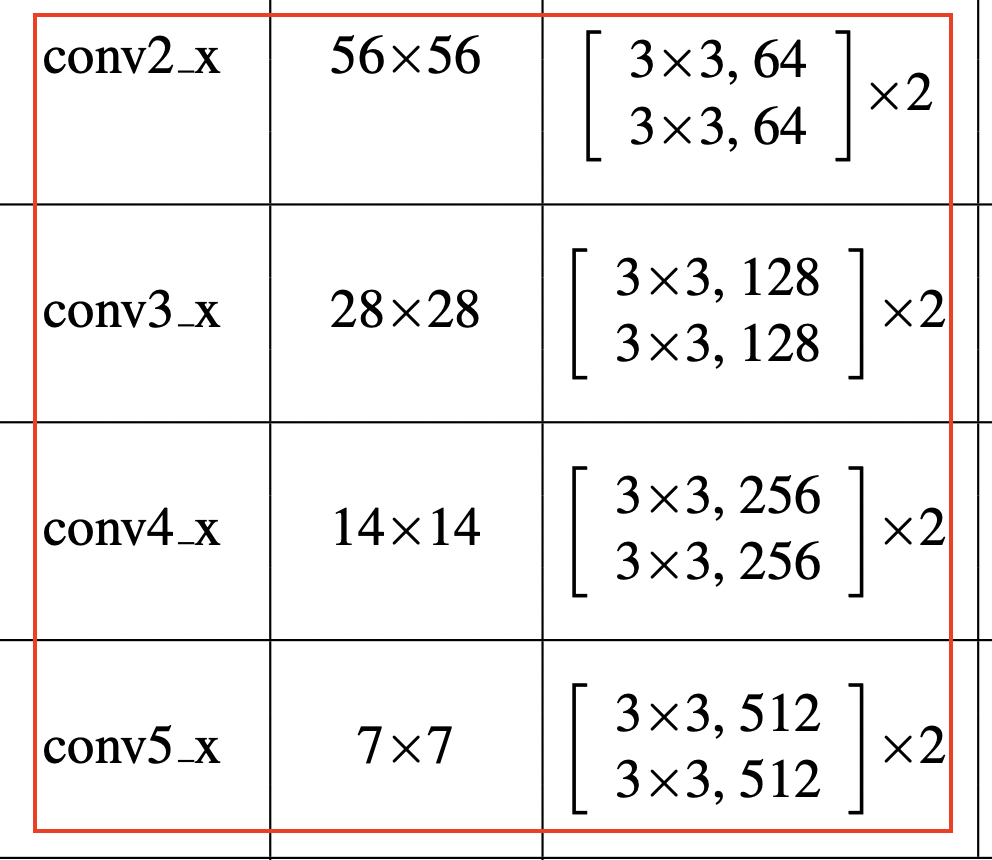

In [7]:
blks_1 = blks(64, 64, 2)
blks_2 = blks(64, 128, 2, first_block=True)
blks_3 = blks(128, 256, 2, first_block=True)
blks_4 = blks(256, 512, 2, first_block=True)

In [8]:
# Build input part
blks_0 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                       nn.BatchNorm2d(64),
                       nn.ReLU(),
                       nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

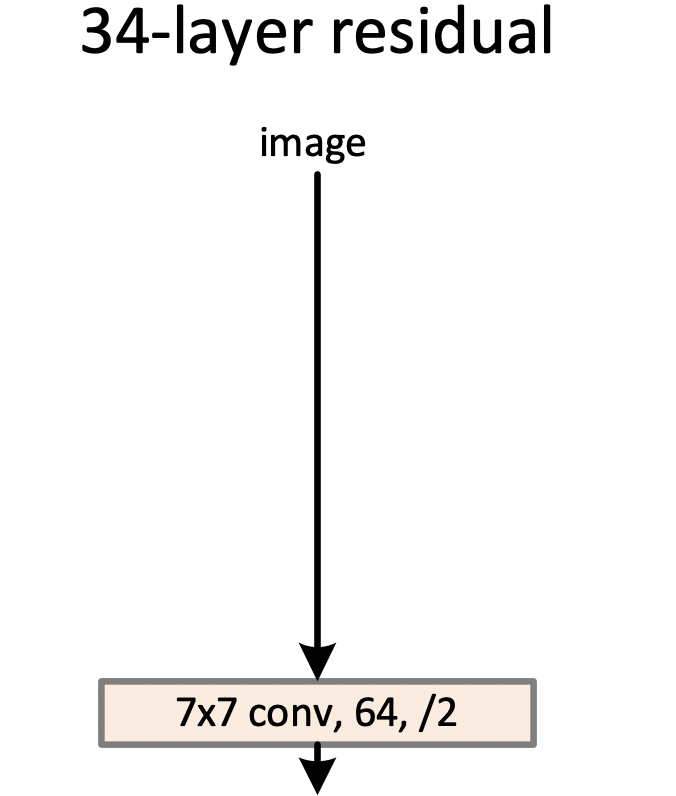

In [9]:
net = nn.Sequential(blks_0, blks_1, blks_2, blks_3, blks_4,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(),
                    nn.Linear(512, 10))

In [10]:
x = torch.randn(1, 1, 224, 224)
for layer in net:
  x = layer(x)
  print(layer.__class__.__name__,'output shape: ', x.shape)

Sequential output shape:  torch.Size([1, 64, 56, 56])
Sequential output shape:  torch.Size([1, 64, 56, 56])
Sequential output shape:  torch.Size([1, 128, 28, 28])
Sequential output shape:  torch.Size([1, 256, 14, 14])
Sequential output shape:  torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:  torch.Size([1, 512, 1, 1])
Flatten output shape:  torch.Size([1, 512])
Linear output shape:  torch.Size([1, 10])


In [11]:
# GPU
def try_gpu(i=0):
  if torch.cuda.device_count() >= i+1:
    return torch.device(f'cuda:{i}')
  return torch.device('cpu')

In [12]:
batch_size = 300
num_epochs = 10
lr = 0.01
train_loader = DataLoader(train_data, batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size, shuffle=True)
l = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

In [13]:
# Move network models to GPU
net = net.to(device=try_gpu())

In [14]:
def validation(model, data_loader, device):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for imgs, label in data_loader:
          imgs = imgs.to(device=device)
          label = label.to(device=device)
          y = model(imgs)
          _, predicted = torch.max(y, dim=1)
          correct += (predicted == label).sum()
          total += label.size(0)
    return correct / total

In [17]:
def train_and_test(num_epochs, model, loss_function, optim, valid, train, test, device, figsize):
  loss_value = []
  acc_value = []
  for epoch in range(num_epochs):
    batch_loss = []
    for i, (img, label) in enumerate(train):
      img = img.to(device=device)
      label = label.to(device=device)
      l = loss_function(model(img), label)
      batch_loss.append(l.item())
      optim.zero_grad()
      l.backward()
      optim.step()
      batch_loss.append(l.item())
      if (i+1) % 100 == 0:
        print(f'Step:{i+1}/{len(train)}, Epoch:{epoch+1}/{num_epochs}, Loss:{l.item():.4f}')
    avg_loss = sum(batch_loss) / len(batch_loss)
    loss_value.append(avg_loss)
    accuracy = valid(model, test, device)
    # The data is stored on the GPU, first moved to the CPU, and then converted to Python scalars.
    acc_value.append(accuracy.item())

    print(f'Step:{i+1}/{len(train)}, Epoch:{epoch+1}/{num_epochs}, Accuracy:{accuracy:.2f}')
  plot_loss_acc(loss_value, acc_value, figsize, num_epochs)

Step:100/200, Epoch:1/10, Loss:0.1831
Step:200/200, Epoch:1/10, Loss:0.0963
Step:200/200, Epoch:1/10, Accuracy:0.09
Step:100/200, Epoch:2/10, Loss:1.6512
Step:200/200, Epoch:2/10, Loss:0.3809
Step:200/200, Epoch:2/10, Accuracy:0.88
Step:100/200, Epoch:3/10, Loss:0.2031
Step:200/200, Epoch:3/10, Loss:0.1745
Step:200/200, Epoch:3/10, Accuracy:0.94
Step:100/200, Epoch:4/10, Loss:0.1232
Step:200/200, Epoch:4/10, Loss:0.0996
Step:200/200, Epoch:4/10, Accuracy:0.97
Step:100/200, Epoch:5/10, Loss:0.0668
Step:200/200, Epoch:5/10, Loss:0.0484
Step:200/200, Epoch:5/10, Accuracy:0.98
Step:100/200, Epoch:6/10, Loss:0.0627
Step:200/200, Epoch:6/10, Loss:0.0962
Step:200/200, Epoch:6/10, Accuracy:0.98
Step:100/200, Epoch:7/10, Loss:0.0726
Step:200/200, Epoch:7/10, Loss:0.0738
Step:200/200, Epoch:7/10, Accuracy:0.98
Step:100/200, Epoch:8/10, Loss:0.0300
Step:200/200, Epoch:8/10, Loss:0.0420
Step:200/200, Epoch:8/10, Accuracy:0.99
Step:100/200, Epoch:9/10, Loss:0.1025
Step:200/200, Epoch:9/10, Loss:0.0

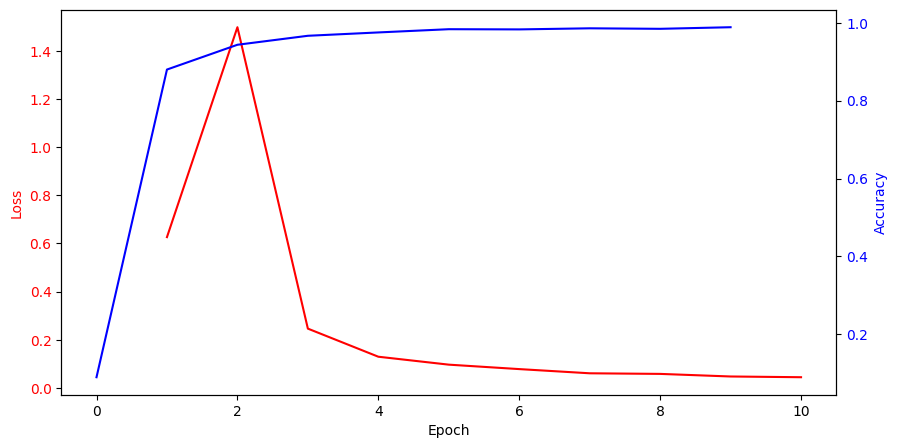

In [16]:
train_and_test(num_epochs, net, l, optimizer, validation, train_loader, test_loader, try_gpu(), figsize=(10, 5))